# 0 Установка библиотек и гиперпараметров

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import datetime
import os

/home/cooper/my_projects/my-car-classification/my_env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Входной размер изображений соответтсвует модели EfficiennetBo
IMG_SIZE = (224, 224)
TRAINING_DIR = "./data/train/"
VALIDATION_DIR = "./data/validation/"
CLASSES = ['bmw_x5', 'land_cruiser', 'qashqai', 'solyaris', 'vaz_2110']

In [3]:
# Создадим callback и место записи логитов
log_dir = "./logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
# Создаcоздадим callback  для чекпоинтов, чтобы сохранить модель для последующего использования 
CHECKPOINT_PATH = "./checkpoint/model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(CHECKPOINT_PATH,
                                                         save_weights_only=True, # сохраним только веса модели
                                                         monitor="val_accuracy", # сохранить веса модели, которые обеспечивают наилучшую точность валидации
                                                         save_best_only=True)

# 1 Загрузка данных и препроцессинг

ImageDataGenerator...
Создание загрузчиков данных (подготовка данных)
Теперь, когда мы загрузили данные, давайте воспользуемся классом ImageDataGenerator вместе с методом flow_from_directory для загрузки наших изображений.
Пример файловой структуры:

data <- top level folder
└───train <- training images
│   └───bmw_x5
│   │   │   x1.jpg
│   │   │   x2.jpg
│   │   │   ...      
│   └───land_cruiser
│       │   l1.jpg
│       │   l2.jpg
│       │   ...
|    ....
│       
└───validation <- validation images
│   └───bmw_x5
│   │   │   x29.jpg
│   │   │   x30.jpg
│   │   │   ...      
│   └───land_cruiser
│       │   l29.jpg
│       │   l30.jpg
│       │   ...
|   ...
└───test <- testing images
    └─── l40.jpg
    └─── q40.jpg
    |
    ...

In [4]:
# Загружаем набор изображений с помощью ImageDataGenerator с применением аугментации для тренировочного набора
training_datagen = ImageDataGenerator(rotation_range=40,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      shear_range=0.2,
                                      zoom_range=0.2,
                                      horizontal_flip=True,
                                      fill_mode='nearest')

validation_datagen = ImageDataGenerator()

train_generator = training_datagen.flow_from_directory(TRAINING_DIR,
                                                        target_size=IMG_SIZE,
                                                        class_mode='categorical',batch_size=32)

validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                                target_size=IMG_SIZE,
                                                                class_mode='categorical',
                                                                shuffle=False,batch_size=32)

Found 130 images belonging to 5 classes.
Found 45 images belonging to 5 classes.


# 2 Создание  и обучение модели

In [5]:
# Загрузим модель EfficientNetB0, предварительно обученную на наборе Imagenet,
# исключив полносвязный верхинй слой и заморозив для обучения остальные 
base_model = tf.keras.applications.EfficientNetB0(input_shape=(224,224,3), include_top=False)
base_model.trainable = False

2022-04-10 18:41:57.757915: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2022-04-10 18:41:57.757942: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: cooper-GL65-Leopard-10SDK
2022-04-10 18:41:57.757947: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: cooper-GL65-Leopard-10SDK
2022-04-10 18:41:57.758038: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 460.106.0
2022-04-10 18:41:57.758054: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 460.106.0
2022-04-10 18:41:57.758059: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 460.106.0
2022-04-10 18:41:57.758248: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU in

In [6]:
# Можем посмотреть состав модели и убедиться, что слои заморожены, а выход модели имеет размерность (None, 7, 7, 1280)
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 225, 225, 3)  0           ['normalization[0][0

In [7]:
# Настройка архитектуры модели с обучаемыми верхними слоями
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer") # форма входного изображения
x = base_model(inputs, training=False) # поместим базовую модель в режим вывода, чтобы мы могли использовать ее для извлечения признаков без обновления весов
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling")(x) # объединим результаты базовой модели
x = tf.keras.layers.Dropout(0.5)(x) # применим дропаут для устранения переобучения
outputs = tf.keras.layers.Dense(5, activation="softmax", name="output_layer")(x) # то же количество выходов, что и у классов
model = tf.keras.Model(inputs, outputs)

In [8]:
# Теперь наша модель выглядит так, обучаемых параметров получается в районе 6,5 тыс
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 output_layer (Dense)        (None, 5)                 6405      
                                                                 
Total params: 4,055,976
Trainable params: 6,405
Non-trainable params: 4,049,571
_______________________________________________

In [9]:
# Компиляция
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(), # используем Адама с настройками по умолчанию
              metrics=["accuracy"])

# Тренировка
history = model.fit(train_generator,
                                           epochs=30, # осуществим тренировку на 30 эпохах
                                           validation_data=validation_generator,                                          
                                           callbacks=[checkpoint_callback,tensorboard_callback]) # сохраним лучшие веса моделей в файл

/home/cooper/my_projects/my-car-classification/my_env/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/30
5/5 [==============================] - 8s 1s/step - loss: 1.8284 - accuracy: 0.2077 - val_loss: 1.6996 - val_accuracy: 0.1778
Epoch 2/30
5/5 [==============================] - 4s 815ms/step - loss: 1.6979 - accuracy: 0.2923 - val_loss: 1.6014 - val_accuracy: 0.2222
Epoch 3/30
5/5 [==============================] - 4s 877ms/step - loss: 1.5371 - accuracy: 0.2769 - val_loss: 1.5255 - val_accuracy: 0.3333
Epoch 4/30
5/5 [==============================] - 4s 862ms/step - loss: 1.4775 - accuracy: 0.3615 - val_loss: 1.4448 - val_accuracy: 0.4000
Epoch 5/30
5/5 [==============================] - 4s 830ms/step - loss: 1.4185 - accuracy: 0.3923 - val_loss: 1.3651 - val_accuracy: 0.4444
Epoch 6/30
5/5 [==============================] - 4s 860ms/step - loss: 1.3236 - accuracy: 0.4154 - val_loss: 1.2944 - val_accuracy: 0.5333
Epoch 7/30
5/5 [==============================] - 4s 1s/step - loss: 1.1887 - accuracy: 0.5308 - val_loss: 1.2285 - val_accuracy: 0.6667
Epoch 8/30
5/5 [==========

In [10]:
# Загрузим веса модели с лучшими показателями val_accuracy так
model.load_weights(CHECKPOINT_PATH)

In [11]:
# Оценка модели на валидационном наборе данных
results_feature_extraction_model = model.evaluate(validation_generator)
results_feature_extraction_model

2/2 [==============================] - 1s 182ms/step - loss: 0.7514 - accuracy: 0.9111


[0.7514132857322693, 0.9111111164093018]

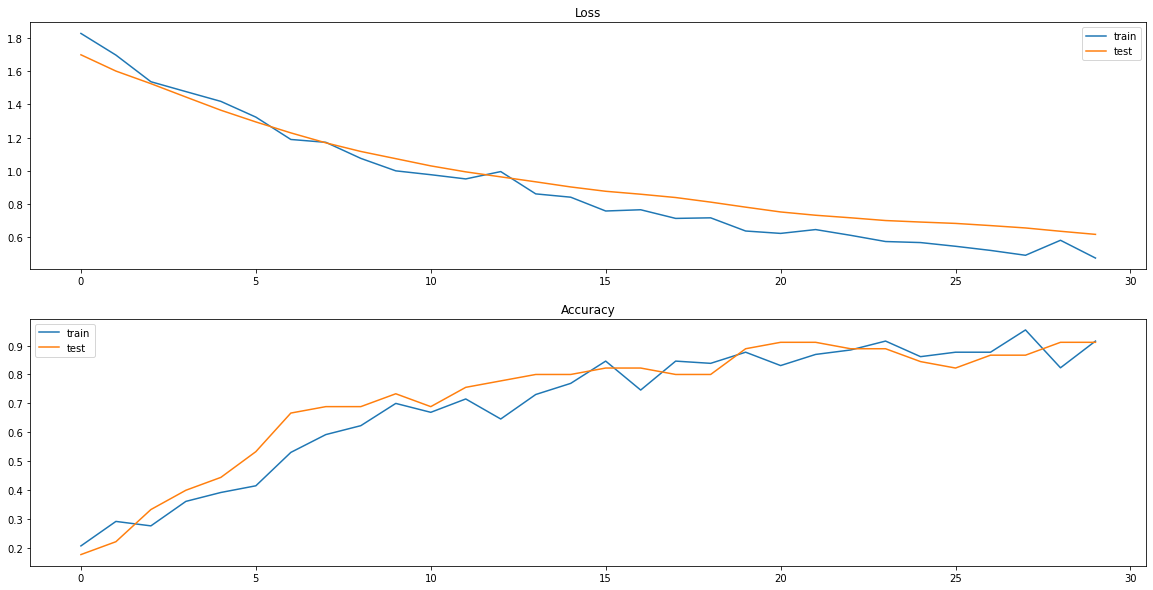

In [12]:
# График потерь во время обучения
plt.rcParams["figure.figsize"] = (20,10)
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
# График точности во время обучения
plt.subplot(212)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

Результаты достаточно неплохие, accuracy выходит на плато  в районе 0,85-0,9, так же можно выделить 
незначительное переобучнение, но мы хотим лучших результатов по этому переходим дальше

# 3 Тонкая настройка

Для нашего следующего эксперимента мы собираемся переключиться на тонкую настройку трансферного обучения. Это означает, что мы будем использовать ту же базовую модель, за исключением того, что мы разморозим некоторые из ее слоев (ближайшие к вершине) и запустим модель еще на несколько эпох.

Идея тонкой настройки состоит в том, чтобы начать настраивать предварительно обученную модель в большей степени на наши собственные данные.

In [13]:
# Оставим замороженными все слои кроме последних 10, их мы попытаемся обучить вместе с нашей моделью
base_model.trainable = True

for layer in base_model.layers[:-10]:
    layer.trainable = False

In [15]:
# Setup model architecture with trainable top layers
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer") # форма входного изображения
x = base_model(inputs) # поместим базовую модель в режим вывода, чтобы мы могли использовать ее для извлечения признаков без обновления весов
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling")(x)  # объединим результаты базовой модели
x = tf.keras.layers.Dropout(0.5)(x) # применим дропаут для устранения переобучения
outputs = tf.keras.layers.Dense(5, activation="softmax", name="output_layer")(x) # то же количество выходов, что и у классов
model_unfreez = tf.keras.Model(inputs, outputs)

In [16]:
# Вывод модели показывает, что количество обучаемых параметров выросло с 6,5 до 900 тыс. 
# за счет разморозки слоев efficientnetb0
model_unfreez.summary() 

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 output_layer (Dense)        (None, 5)                 6405      
                                                                 
Total params: 4,055,976
Trainable params: 899,637
Non-trainable params: 3,156,339
___________________________________________

In [17]:

# Compile
model_unfreez.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(), # use Adam with default settings
              metrics=["accuracy"])

# Fit
history_unfreez = model_unfreez.fit(train_generator,
                                           epochs=30, # # осуществим тренировку на 30 эпохах
                                           validation_data=validation_generator,
                                           callbacks=[checkpoint_callback,tensorboard_callback]) # сохраним лучшие веса моделей в файл

Epoch 1/30
5/5 [==============================] - 8s 1s/step - loss: 1.4760 - accuracy: 0.4000 - val_loss: 1.3323 - val_accuracy: 0.3778
Epoch 2/30
5/5 [==============================] - 4s 1s/step - loss: 0.8594 - accuracy: 0.7385 - val_loss: 1.0966 - val_accuracy: 0.4222
Epoch 3/30
5/5 [==============================] - 4s 809ms/step - loss: 0.6643 - accuracy: 0.8308 - val_loss: 0.7739 - val_accuracy: 0.6222
Epoch 4/30
5/5 [==============================] - 4s 853ms/step - loss: 0.3806 - accuracy: 0.9462 - val_loss: 0.4839 - val_accuracy: 0.8444
Epoch 5/30
5/5 [==============================] - 4s 902ms/step - loss: 0.2597 - accuracy: 0.9615 - val_loss: 0.3362 - val_accuracy: 0.8667
Epoch 6/30
5/5 [==============================] - 4s 1s/step - loss: 0.1838 - accuracy: 0.9615 - val_loss: 0.2657 - val_accuracy: 0.8889
Epoch 7/30
5/5 [==============================] - 4s 854ms/step - loss: 0.1489 - accuracy: 0.9692 - val_loss: 0.2497 - val_accuracy: 0.9111
Epoch 8/30
5/5 [=============

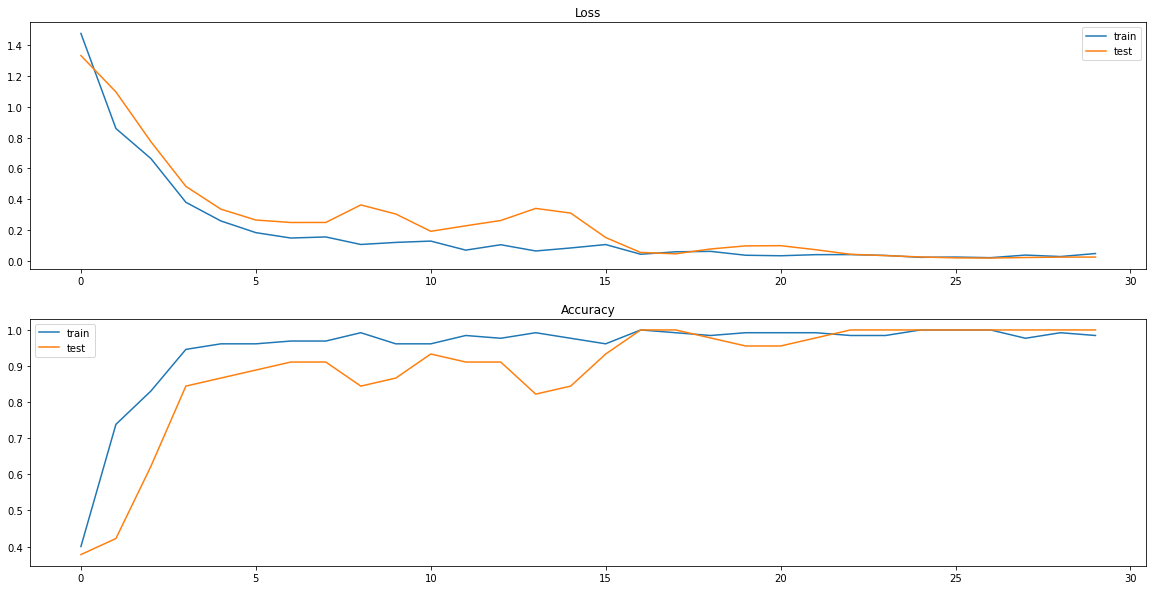

In [18]:
plt.rcParams["figure.figsize"] = (20,10)
plt.subplot(211)
plt.title('Loss')
plt.plot(history_unfreez.history['loss'], label='train')
plt.plot(history_unfreez.history['val_loss'], label='test')
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(history_unfreez.history['accuracy'], label='train')
plt.plot(history_unfreez.history['val_accuracy'], label='test')
plt.legend()
plt.show()

Точность равную 1 мы получили примерно через 15 эпох обучения, далее мы наблюдаем  незначительные колебания в районе единицы, переобучения практически избежали 


In [19]:
#загрузим веса модели с наилучшими параметрами val_accuracy за период обучения
model_unfreez.load_weights(CHECKPOINT_PATH)

In [20]:
# Оценка модели на валидационном наборе данных
results_all_fine_tune = model_unfreez.evaluate(validation_generator)
results_all_fine_tune

2/2 [==============================] - 1s 185ms/step - loss: 0.0552 - accuracy: 1.0000


[0.05518930405378342, 1.0]

# 4 Оценка модели

# 4.1 Tensorboard

In [21]:
# !tensorboard --logdir logs/fit

TensorBoard предоставляет визуализацию и инструменты, необходимые для экспериментов с машинным обучением:
- Отслеживание и визуализация таких показателей, как потери и точность
- Визуализация графа модели (операции и слои)
- Просмотр гистограмм весов, смещений или других тензоров по мере их изменения во времени
- Проецирование вложений в пространство более низкой размерности
- Отображение изображений, текста и аудиоданных
- И многое друго

Визуализация потери и точности:

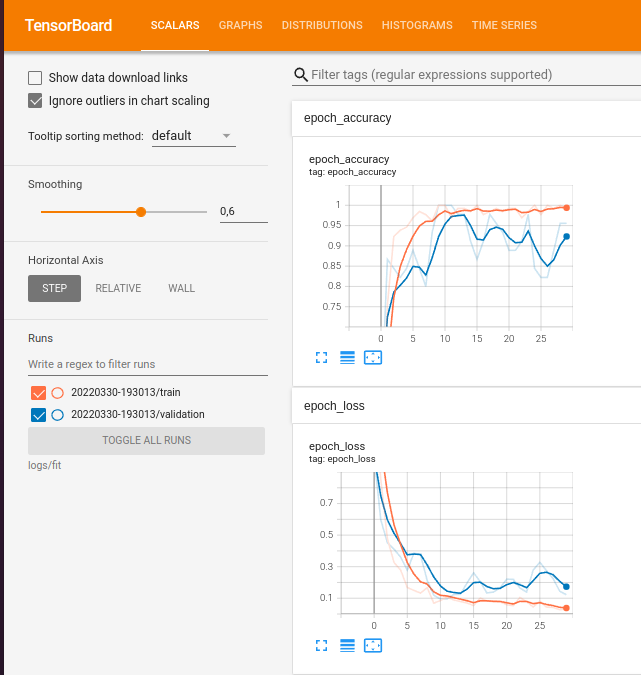

Гистограмма весов и смещений:


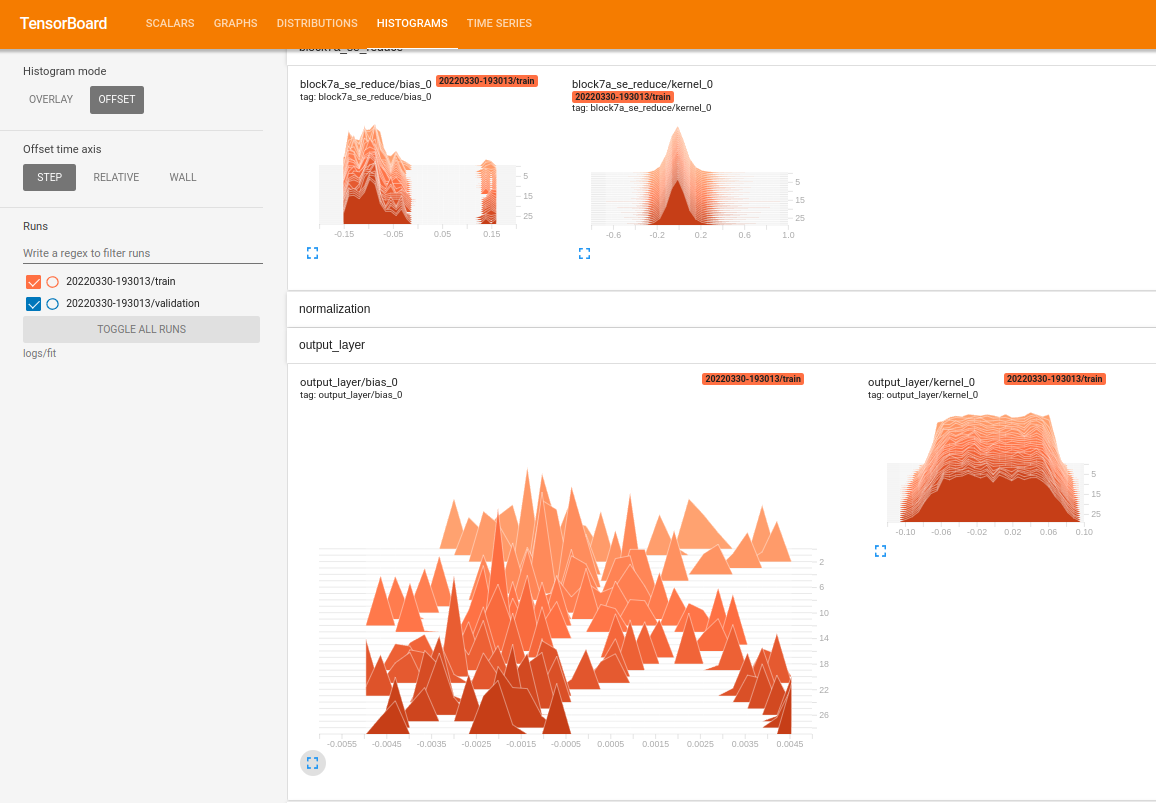

Визуализация графа модели:

# 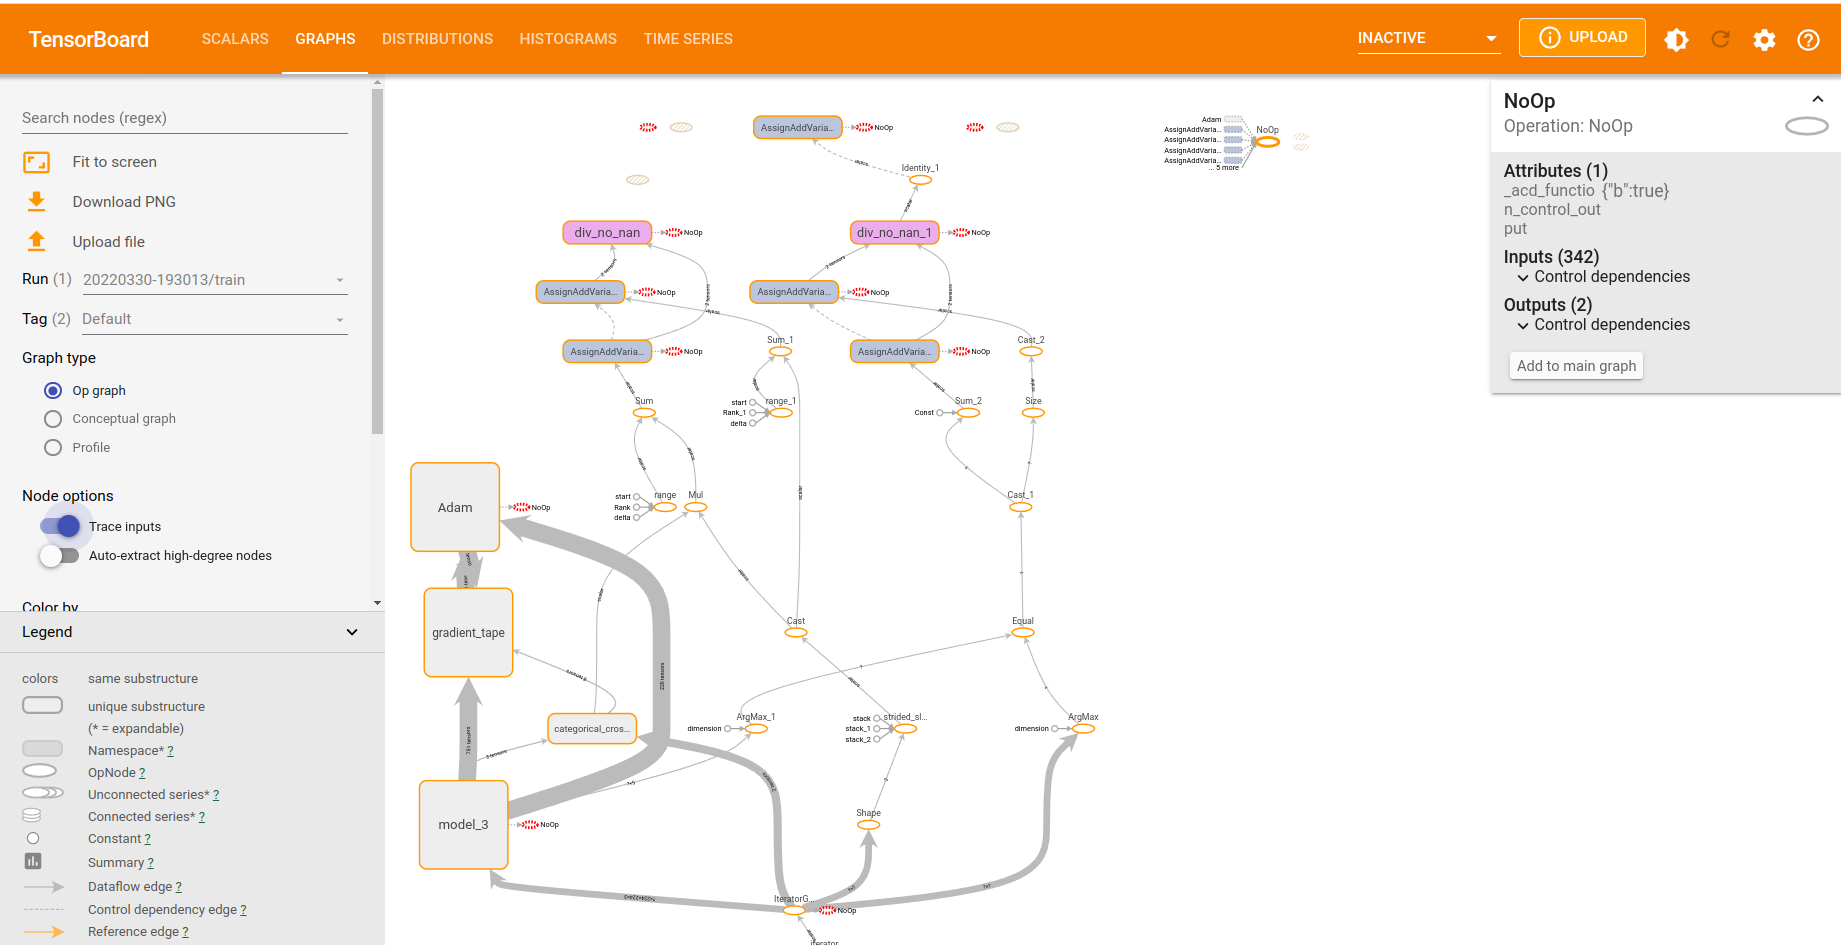


# 4.2 Получение предсказаний

In [22]:
# Чтение изображения в numpy массив  размерностью (1, 224, 224, 3) и (224, 224, 3)
def read_img(link):
    # чтение изображения
    img = cv2.imread(link)
    # форматирование RGB 
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    # resize \ 224 х 224
    img = cv2.resize(img, (224, 224)) 
    # добавление размерности batch
    image_expand = np.expand_dims(img, axis=0)
    return image_expand, img

In [23]:
# Получение предсказаний
def predictions_img(link = './data/test/2110.jpeg'):
    # read the image
    _, img = read_img(link)
    # add a batch dimension in front
    image = np.expand_dims(img, axis=0)
    predictions = model_unfreez.predict(image, verbose=1)
    return predictions

In [24]:
#При использовании функции актвации softmax на выходе модели получаем вектор из действительных чисел [0,1] 
predictions = predictions_img('./data/test/l3.jpeg')
predictions

1/1 [==============================] - 1s 782ms/step


array([[1.1065681e-03, 9.9746931e-01, 6.3452113e-05, 2.5307985e-05,
        1.3353464e-03]], dtype=float32)

In [25]:
# Трансформируем векторное представление в предсказанный класс
predict_class = CLASSES[np.argmax(predictions)]
predict_class

'land_cruiser'

In [26]:
# Ну и собственно исходное изображение с предсказанием
def show(link='./data/test/l4.jpeg'):
    img = cv2.imread(link)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.title(predict_class)
    plt.show()

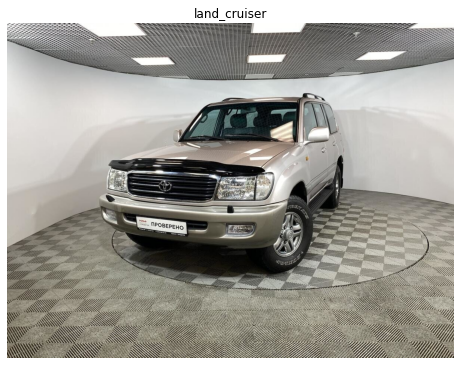

In [27]:
show('./data/test/l4.jpeg')

#  4.3 Корреляционная матрица

Вставить описание о кореляционнй матрице

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [29]:
# Переобразуем  валидационные данные из формата ImageDataGenerator в numpy массив. 
# это будет удобно для дальнейшего представления
val_images, val_labels = next(validation_datagen.flow_from_directory(VALIDATION_DIR,batch_size=45, shuffle=False))

Found 45 images belonging to 5 classes.


In [30]:
# Преобразуем выходы софтмакса в целевые значения
pred_probs = np.argmax(model_unfreez.predict(validation_generator, verbose=1), axis=1)
val_labels_true=np.argmax(val_labels, axis=1)

2/2 [==============================] - 1s 187ms/step


In [31]:
# Создадим корреляционную матрицу
cm = confusion_matrix(y_true=val_labels_true, y_pred=pred_probs, normalize='true')
cm

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])

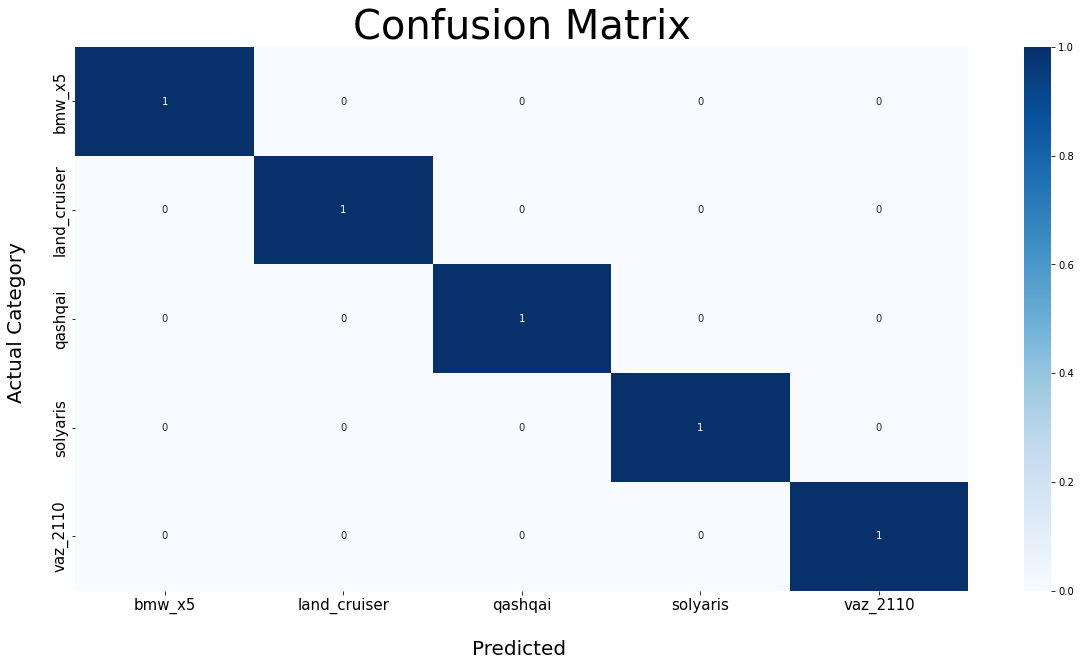

In [32]:
# Востпользуемся тепловым представлением  корреляционной матрицы с помощью бибилотеки seaborn\
ax = sns.heatmap(cm, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix',fontsize=40);
ax.set_xlabel('\nPredicted ',fontsize=20)
ax.set_ylabel('Actual Category \n',fontsize=20);

# Ярлыки значений
ax.xaxis.set_ticklabels(CLASSES,fontsize=15)
ax.yaxis.set_ticklabels(CLASSES,fontsize=15)

# Представление матрицы
plt.show()


Хорошая новость заключается в том, что все правильные прогнозы располагаются справа от верхнего левого угла до нижнего правого диагонали, что означает, что они верны. Возможно данный метод кажется бесполезным, но при увеличении количества классов ошибочные предсказания начнут появляться и данное представление поможет выяснить какие классы между собой коррелируют.

Поскольку мы работаем над проблемой классификации, мы можем дополнительно оценить прогнозы нашей модели, используя функцию Scikit-Learn Classification_report(). Подробно на этом методе оценки останавливаться не будем так, как результат у нас абсолютно верный, только отметим, что Classification_report() выводит precision, recall and f1-score для каждого класса.

Напоминание:

precision — доля истинных положительных результатов от общего количества образцов. Более высокая точность приводит к меньшему количеству ложных срабатываний (модель предсказывает 1, когда должно было быть 0).

recall — доля истинных положительных результатов по отношению к общему количеству истинных положительных и ложных отрицательных результатов (модель предсказывает 0, когда должно было быть 1). Чем выше отзыв, тем меньше ложноотрицательных результатов.

f1-score — объединяет точность и полноту в одну метрику. 1 — лучший, 0 — худший.

In [33]:
# Построимтекстовый отчет,показывающий основные метрики классификации.
from sklearn.metrics import classification_report
print(classification_report(val_labels_true, pred_probs))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00         9
           3       1.00      1.00      1.00         9
           4       1.00      1.00      1.00         9

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45



# 6.4 Карты значимости

Карты значимости (Saliency map) — это метод визуализации, позволяющий лучше понять на чем фокусируется нейронная сеть при принятии решений. 

Мы рассмортим градиентный подход, алгоритм обратного распространения для вычисления градиентов логитов на вход сети(обратите внимание, что в алгоритме обратного распространения, используемом для обучения сети, градиенты вычисляются относительно параметров сети). Используя обратное распространение, мы можем выделить пиксели входного изображения в зависимости от полученного ими градиента, что показывает их вклад в итоговую оценку. Статья: https://arxiv.org/pdf/1312.6034.pdf.


In [34]:
# Чтение изображения в numpy массив  размерностью (1, 224, 224, 3) и (224, 224, 3)
def read_img_expand(link):
    # read the image
    img = cv2.imread(link)

    # format it to be in the RGB colorspace
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 

    # resize to 300x300 and normalize pixel values to be in the range [0, 1]
    img = cv2.resize(img, (224, 224)) 

    # add a batch dimension in front
    image_expand = np.expand_dims(img, axis=0)
    return image_expand, img

In [35]:
# ID класса  нашего изображения
class_index = CLASSES.index('land_cruiser')  #1

# Количество классов в обучающих данных модели
num_classes = 5
image_expand, img = read_img_expand(link='./data/test/l2.jpeg')
# Преоюрзуем в one hot представление, чтобы оно соответствовало нашей активации softmax в определении модели
expected_output = tf.one_hot([class_index] * image_expand.shape[0], num_classes)

with tf.GradientTape() as tape:
    # Преобразуем изображение во  float
    inputs = tf.cast(image_expand, tf.float32)
    # Посмотрим входные пиксели
    tape.watch(inputs)
    # Создадим предсказания
    predictions = model_unfreez(inputs)
    # Получим loss
    loss = tf.keras.losses.categorical_crossentropy(
        expected_output, predictions
    )

# Получим градиент относительно входных данных
gradients = tape.gradient(loss, inputs)

In [36]:
# Уменьшим изображение RGB до оттенков серого
grayscale_tensor = tf.reduce_sum(tf.abs(gradients), axis=-1)

# Нормализуем значения пикселей градиента, чтобы они находились в диапазоне [0, 255].
normalized_tensor = tf.cast(
    255 * (grayscale_tensor - tf.reduce_min(grayscale_tensor))
    / (tf.reduce_max(grayscale_tensor) - tf.reduce_min(grayscale_tensor)),
    tf.uint8,
)

# Преобразуем в двумерный тензор
normalized_tensor = tf.squeeze(normalized_tensor)

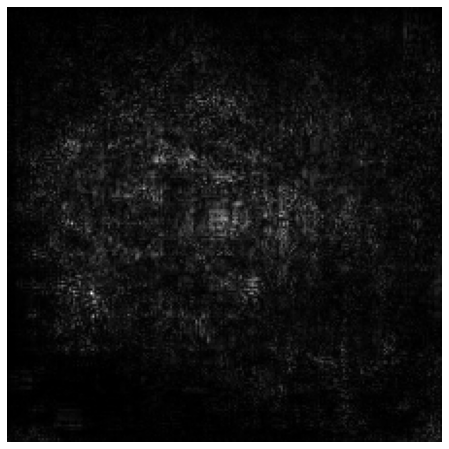

In [37]:
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.imshow(normalized_tensor, cmap='gray')
plt.show()


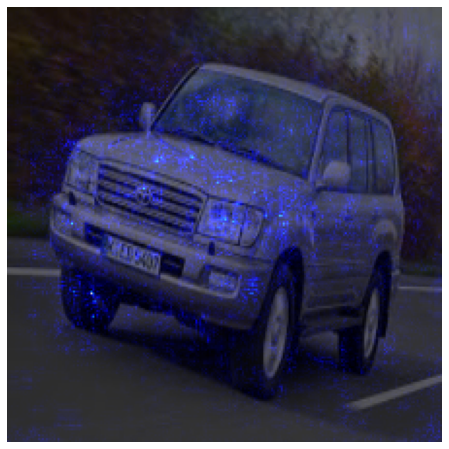

In [38]:
# Совместим исходное изображение с изображением градиента
gradient_color = cv2.applyColorMap(normalized_tensor.numpy(), cv2.COLORMAP_HOT)
super_imposed = cv2.addWeighted(img, 0.4, gradient_color, 0.8, 0.0)
plt.figure(figsize=(8, 8))
plt.imshow(super_imposed)
plt.axis('off')
plt.show()

Мы видим, что карта значимости сконцентрирована в основном на переднейчасти автомобиля, что обнадеживает, поскольку это означает, что модель смотрит практически только на автомобиль, а не на что-либо еще, чтобы сделать свой прогноз

# 5 Сохранение модели

In [39]:
# Сохраняем всю модель как models/car_classification/
MODEL_DIR = "models/car-classification/"
version = 1
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path = {}\n'.format(export_path))
tf.keras.models.save_model(
    model, # экземпляр модели  для сохранения
    export_path #  путь для сохранения модели
)

export_path = models/car-classification/1



2022-04-10 18:47:32.382770: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: models/car-classification/1/assets


/home/cooper/my_projects/my-car-classification/my_env/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/home/cooper/my_projects/my-car-classification/my_env/lib/python3.8/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)
